# References


## General
- [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- [Human Level Control Through Deep Reinforcement Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

## Double Q-Learning
- [Double Q-Learning](https://papers.nips.cc/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf)
- [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)
- [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477)
- [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)

## Experience Replay
- [A Deeper Look at Experience Replay](https://arxiv.org/abs/1712.01275)
- [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)
- [Double Learning and Prioritized Experience Replay](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/)

## Tutorial
- [PyTorch Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [towards data science: Double Deep Q Networks](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)
- [PyLessons Reinforcement Learning Tutorial](https://pylessons.com/Reinforcement-learning-tutorial/)

# Import

In [1]:
import time
import random
import math
from copy import deepcopy
from collections import namedtuple, deque
from itertools import count, product
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import logger
logger.set_level(gym.logger.DISABLED)
from replay_buffer import ReplayBuffer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Replay Buffer

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = int(buffer_size)
        self.buffer = []
        self.index = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(None)
        self.buffer[self.index] = Transition(state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.buffer_size
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# CartPole Environment

In [3]:
env = gym.make('CartPole-v1')

# Neural Network

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN Agent

In [27]:
class Agent:
    def __init__(self, config, nn):
        self.step = 0
        self.gamma = config["gamma"]
        self.batch_size = config["batch_size"]
        self.replay_buffer = ReplayBuffer(config["buffer_size"])
        self.n_gradient_steps = config["n_gradient_steps"]
        self.n_actions = config["n_actions"]
        self.epsilon = config["epsilon_max"]
        self.epsilon_max = config["epsilon_max"]
        self.epsilon_min = config["epsilon_min"]
        self.epsilon_decay = config["epsilon_decay"]
        self.nn = nn.to(device)
        self.target_nn = deepcopy(self.nn).to(device)
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.RMSprop(self.nn.parameters(), lr=config["learning_rate"])
        self.option = config["option"]
        if "beta" in config:
            self.beta = config["beta"]
            self.update_target_nn = self.smooth_update_target_nn
        elif "C" in config:
            self.C = config["C"]
            self.update_target_nn = self.periodic_update_target_nn
        else:
            self.update_target_nn = (lambda: None)
            self.option = 0
    
    def update_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-1. * self.step / self.epsilon_decay)
    
    def epsilon_greedy_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                return torch.argmax(self.nn(torch.Tensor(state))).item()
        else:
            return torch.tensor(random.randrange(self.n_actions), device=device, dtype=torch.long).item()
    
    def greedy_action(self, state):
        with torch.no_grad():
            return torch.argmax(self.nn(torch.Tensor(state))).item()
    
    def gradient_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
        done_batch = torch.stack(batch.done)
        
        state_action_values = self.nn(state_batch).gather(1, action_batch)
        if self.option == 2:
            # Double Q-Learning
            next_state_action_values = self.target_nn(next_state_batch).gather(1, self.nn(next_state_batch).max(1)[1].unsqueeze(1)).detach()
        elif self.option == 1:
            # Target
            next_state_action_values = self.target_nn(next_state_batch).max(1)[0].unsqueeze(1).detach()
        else:
            # Vanilla
            next_state_action_values = self.nn(next_state_batch).max(1)[0].unsqueeze(1).detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_action_values * (1 - done_batch)
        
        loss = self.criterion(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_target_nn()
    
    def periodic_update_target_nn(self):
        if self.step % self.C == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())  
    
    def smooth_update_target_nn(self):
        for param_nn, param_target_nn in zip(self.nn.parameters(), self.target_nn.parameters()):
            param_target_nn.data.copy_(param_nn * self.beta + param_target_nn * (1 - self.beta))
    
    def train(self, env, n_episodes):
        episode_return_list = []
        for i_episode in range(1, n_episodes+1):
            episode_return = 0
            state = env.reset()
            for t in count():
                self.update_epsilon()
                action = self.epsilon_greedy_action(state)
                next_state, reward, done, _ = env.step(action)
                episode_return += reward
                
                self.replay_buffer.add(torch.Tensor(state), torch.tensor([action], dtype=torch.long), torch.tensor([reward], dtype=torch.float), torch.Tensor(next_state), torch.tensor([int(done)], dtype=torch.long))
                state = next_state
                self.step += 1
                
                for _ in range(self.n_gradient_steps):
                    self.gradient_step()
                
                if done:
                    episode_return_list.append(episode_return)
                    print("Episode {:4d} : {:4d} steps | epsilon = {:4.2f} | return = {:.1f}".format(i_episode, t+1, self.epsilon, episode_return))
                    break
        return episode_return_list
    
    def test(self, env, step_max):
        episode_return = 0
        state = env.reset()
        for t in count():
            env.render()
            action = self.greedy_action(state)
            next_state, reward, done, _ = env.step(action)
            episode_return += reward
            
            state = next_state

            if done or t+1 >= step_max:
                env.close()
                return episode_return
    
    def save(self, name):
        torch.save(self.nn.state_dict(), "trained_nn/{}.pt".format(name))
    
    def load(self, name):
        self.nn.load_state_dict(torch.load("trained_nn/{}.pt".format(name)))

config = {"gamma": 0.95,
          "batch_size": 32,
          "buffer_size": 1e6,
          "n_gradient_steps": 8,
          "n_actions": 2,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 5000,
          "C": 100,
          "option": 2}

dqn = DQN()
agent = Agent(config, dqn)

In [28]:
episode_return_list = agent.train(env, 100)

Episode    1 :   13 steps | epsilon = 1.00 | return = 13.0
Episode    2 :   40 steps | epsilon = 0.99 | return = 40.0
Episode    3 :   31 steps | epsilon = 0.98 | return = 31.0
Episode    4 :   20 steps | epsilon = 0.98 | return = 20.0
Episode    5 :   15 steps | epsilon = 0.98 | return = 15.0
Episode    6 :   47 steps | epsilon = 0.97 | return = 47.0
Episode    7 :   19 steps | epsilon = 0.96 | return = 19.0
Episode    8 :   15 steps | epsilon = 0.96 | return = 15.0
Episode    9 :   19 steps | epsilon = 0.96 | return = 19.0
Episode   10 :   18 steps | epsilon = 0.95 | return = 18.0
Episode   11 :   22 steps | epsilon = 0.95 | return = 22.0
Episode   12 :   13 steps | epsilon = 0.95 | return = 13.0
Episode   13 :   25 steps | epsilon = 0.94 | return = 25.0
Episode   14 :   10 steps | epsilon = 0.94 | return = 10.0
Episode   15 :   14 steps | epsilon = 0.94 | return = 14.0
Episode   16 :   45 steps | epsilon = 0.93 | return = 45.0
Episode   17 :   33 steps | epsilon = 0.92 | return = 33

KeyboardInterrupt: 

In [16]:
agent.test(env, 500)

500.0

In [110]:
agent.save("cartpole.pth")

# Testing

In [13]:
dqn_1 = DQN()
config_1 = {"gamma": 0.95,
          "batch_size": 32,
          "buffer_size": 1e6,
          "n_gradient_steps": 1,
          "n_actions": 2,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 5000,
          "C": 100,
          "option": 0}
agent_1 = Agent(config_1, dqn_1)

dqn_2 = deepcopy(dqn_1)
config_2 = {"gamma": 0.95,
          "batch_size": 32,
          "buffer_size": 1e6,
          "n_gradient_steps": 1,
          "n_actions": 2,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 5000,
          "beta": 0.01,
          "option": 2}
agent_2 = Agent(config_2, dqn_2)

dqn_3 = deepcopy(dqn_1)
config_3 = {"gamma": 0.95,
          "batch_size": 32,
          "buffer_size": 1e6,
          "n_gradient_steps": 1,
          "n_actions": 2,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 5000,
          "C": 100,
          "option": 2}
agent_3 = Agent(config_3, dqn_3)

episode_return_list_1 = agent_1.train(env, 300)
episode_return_list_2 = agent_2.train(env, 300)
episode_return_list_3 = agent_3.train(env, 300)

Episode    1 :   35 steps | epsilon = 0.99 | return = 35.0
Episode    2 :   15 steps | epsilon = 0.99 | return = 15.0
Episode    3 :   14 steps | epsilon = 0.99 | return = 14.0
Episode    4 :   35 steps | epsilon = 0.98 | return = 35.0
Episode    5 :   35 steps | epsilon = 0.97 | return = 35.0
Episode    6 :   16 steps | epsilon = 0.97 | return = 16.0
Episode    7 :   25 steps | epsilon = 0.97 | return = 25.0
Episode    8 :   50 steps | epsilon = 0.96 | return = 50.0
Episode    9 :   15 steps | epsilon = 0.95 | return = 15.0
Episode   10 :   17 steps | epsilon = 0.95 | return = 17.0
Episode   11 :   20 steps | epsilon = 0.95 | return = 20.0
Episode   12 :   34 steps | epsilon = 0.94 | return = 34.0
Episode   13 :   24 steps | epsilon = 0.94 | return = 24.0
Episode   14 :    9 steps | epsilon = 0.93 | return = 9.0
Episode   15 :   20 steps | epsilon = 0.93 | return = 20.0
Episode   16 :   24 steps | epsilon = 0.93 | return = 24.0
Episode   17 :   13 steps | epsilon = 0.92 | return = 13.

Episode  140 :  226 steps | epsilon = 0.16 | return = 226.0
Episode  141 :  167 steps | epsilon = 0.16 | return = 167.0
Episode  142 :  230 steps | epsilon = 0.15 | return = 230.0
Episode  143 :  163 steps | epsilon = 0.15 | return = 163.0
Episode  144 :  249 steps | epsilon = 0.14 | return = 249.0
Episode  145 :  177 steps | epsilon = 0.13 | return = 177.0
Episode  146 :  176 steps | epsilon = 0.13 | return = 176.0
Episode  147 :  167 steps | epsilon = 0.13 | return = 167.0
Episode  148 :  186 steps | epsilon = 0.12 | return = 186.0
Episode  149 :  421 steps | epsilon = 0.11 | return = 421.0
Episode  150 :  258 steps | epsilon = 0.11 | return = 258.0
Episode  151 :  208 steps | epsilon = 0.10 | return = 208.0
Episode  152 :  145 steps | epsilon = 0.10 | return = 145.0
Episode  153 :  342 steps | epsilon = 0.10 | return = 342.0
Episode  154 :  187 steps | epsilon = 0.09 | return = 187.0
Episode  155 :  208 steps | epsilon = 0.09 | return = 208.0
Episode  156 :  183 steps | epsilon = 0.

Episode  277 :  189 steps | epsilon = 0.01 | return = 189.0
Episode  278 :  243 steps | epsilon = 0.01 | return = 243.0
Episode  279 :  374 steps | epsilon = 0.01 | return = 374.0
Episode  280 :  178 steps | epsilon = 0.01 | return = 178.0
Episode  281 :  228 steps | epsilon = 0.01 | return = 228.0
Episode  282 :  392 steps | epsilon = 0.01 | return = 392.0
Episode  283 :  266 steps | epsilon = 0.01 | return = 266.0
Episode  284 :  252 steps | epsilon = 0.01 | return = 252.0
Episode  285 :  192 steps | epsilon = 0.01 | return = 192.0
Episode  286 :  235 steps | epsilon = 0.01 | return = 235.0
Episode  287 :  191 steps | epsilon = 0.01 | return = 191.0
Episode  288 :  198 steps | epsilon = 0.01 | return = 198.0
Episode  289 :  330 steps | epsilon = 0.01 | return = 330.0
Episode  290 :  275 steps | epsilon = 0.01 | return = 275.0
Episode  291 :  207 steps | epsilon = 0.01 | return = 207.0
Episode  292 :  235 steps | epsilon = 0.01 | return = 235.0
Episode  293 :  213 steps | epsilon = 0.

Episode  116 :  500 steps | epsilon = 0.20 | return = 500.0
Episode  117 :  380 steps | epsilon = 0.18 | return = 380.0
Episode  118 :  296 steps | epsilon = 0.17 | return = 296.0
Episode  119 :  345 steps | epsilon = 0.16 | return = 345.0
Episode  120 :  252 steps | epsilon = 0.15 | return = 252.0
Episode  121 :  282 steps | epsilon = 0.15 | return = 282.0
Episode  122 :  500 steps | epsilon = 0.13 | return = 500.0
Episode  123 :  250 steps | epsilon = 0.13 | return = 250.0
Episode  124 :  200 steps | epsilon = 0.12 | return = 200.0
Episode  125 :  273 steps | epsilon = 0.12 | return = 273.0
Episode  126 :  227 steps | epsilon = 0.11 | return = 227.0
Episode  127 :  274 steps | epsilon = 0.11 | return = 274.0
Episode  128 :  293 steps | epsilon = 0.10 | return = 293.0
Episode  129 :  322 steps | epsilon = 0.10 | return = 322.0
Episode  130 :  240 steps | epsilon = 0.09 | return = 240.0
Episode  131 :  247 steps | epsilon = 0.09 | return = 247.0
Episode  132 :  349 steps | epsilon = 0.

Episode  253 :  194 steps | epsilon = 0.01 | return = 194.0
Episode  254 :  225 steps | epsilon = 0.01 | return = 225.0
Episode  255 :  287 steps | epsilon = 0.01 | return = 287.0
Episode  256 :  302 steps | epsilon = 0.01 | return = 302.0
Episode  257 :  318 steps | epsilon = 0.01 | return = 318.0
Episode  258 :  187 steps | epsilon = 0.01 | return = 187.0
Episode  259 :  204 steps | epsilon = 0.01 | return = 204.0
Episode  260 :  257 steps | epsilon = 0.01 | return = 257.0
Episode  261 :  227 steps | epsilon = 0.01 | return = 227.0
Episode  262 :  376 steps | epsilon = 0.01 | return = 376.0
Episode  263 :  246 steps | epsilon = 0.01 | return = 246.0
Episode  264 :  399 steps | epsilon = 0.01 | return = 399.0
Episode  265 :  218 steps | epsilon = 0.01 | return = 218.0
Episode  266 :  197 steps | epsilon = 0.01 | return = 197.0
Episode  267 :  296 steps | epsilon = 0.01 | return = 296.0
Episode  268 :  469 steps | epsilon = 0.01 | return = 469.0
Episode  269 :  195 steps | epsilon = 0.

Episode   91 :   14 steps | epsilon = 0.41 | return = 14.0
Episode   92 :  178 steps | epsilon = 0.40 | return = 178.0
Episode   93 :  154 steps | epsilon = 0.39 | return = 154.0
Episode   94 :  183 steps | epsilon = 0.37 | return = 183.0
Episode   95 :  193 steps | epsilon = 0.36 | return = 193.0
Episode   96 :  205 steps | epsilon = 0.35 | return = 205.0
Episode   97 :  185 steps | epsilon = 0.33 | return = 185.0
Episode   98 :  234 steps | epsilon = 0.32 | return = 234.0
Episode   99 :  266 steps | epsilon = 0.30 | return = 266.0
Episode  100 :  242 steps | epsilon = 0.29 | return = 242.0
Episode  101 :  338 steps | epsilon = 0.27 | return = 338.0
Episode  102 :  238 steps | epsilon = 0.26 | return = 238.0
Episode  103 :  207 steps | epsilon = 0.25 | return = 207.0
Episode  104 :  246 steps | epsilon = 0.24 | return = 246.0
Episode  105 :  318 steps | epsilon = 0.22 | return = 318.0
Episode  106 :  233 steps | epsilon = 0.21 | return = 233.0
Episode  107 :  215 steps | epsilon = 0.2

Episode  228 :  450 steps | epsilon = 0.01 | return = 450.0
Episode  229 :  303 steps | epsilon = 0.01 | return = 303.0
Episode  230 :  249 steps | epsilon = 0.01 | return = 249.0
Episode  231 :  255 steps | epsilon = 0.01 | return = 255.0
Episode  232 :  218 steps | epsilon = 0.01 | return = 218.0
Episode  233 :  263 steps | epsilon = 0.01 | return = 263.0
Episode  234 :  222 steps | epsilon = 0.01 | return = 222.0
Episode  235 :  232 steps | epsilon = 0.01 | return = 232.0
Episode  236 :  364 steps | epsilon = 0.01 | return = 364.0
Episode  237 :  191 steps | epsilon = 0.01 | return = 191.0
Episode  238 :  199 steps | epsilon = 0.01 | return = 199.0
Episode  239 :  209 steps | epsilon = 0.01 | return = 209.0
Episode  240 :  239 steps | epsilon = 0.01 | return = 239.0
Episode  241 :  165 steps | epsilon = 0.01 | return = 165.0
Episode  242 :  169 steps | epsilon = 0.01 | return = 169.0
Episode  243 :  220 steps | epsilon = 0.01 | return = 220.0
Episode  244 :  373 steps | epsilon = 0.

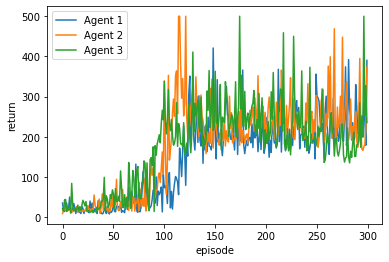

In [14]:
plt.plot(episode_return_list_1, label="Agent 1")
plt.plot(episode_return_list_2, label="Agent 2")
plt.plot(episode_return_list_3, label="Agent 3")
plt.xlabel("episode")
plt.ylabel("return")
plt.legend()
plt.show()

# CartPole Swing Up Environment

In [111]:
class CartPoleSwingUp(gym.Wrapper):
    def __init__(self, env, **kwargs):
        super(CartPoleSwingUp, self).__init__(env, **kwargs)
        self.theta_dot_threshold = 4*np.pi

    def reset(self):
        self.env.env.state = [0, 0, np.pi, 0] + super().reset()
        self.env.env.steps_beyond_done = None
        return np.array(self.env.env.state)

    def step(self, action):
        state, reward, done, _ = super().step(action)
        x, x_dot, theta, theta_dot = state
        
        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta_dot < -self.theta_dot_threshold \
               or theta_dot > self.theta_dot_threshold
        
        if done:
            # game over
            reward = -10.
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0
            else:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
        else:
            if -self.theta_threshold_radians < theta and theta < self.theta_threshold_radians:
                # pole upright
                reward = 1.
            else:
                # pole swinging
                reward = 0.

        return np.array(self.state), reward, done, {}

env = CartPoleSwingUp(gym.make('CartPole-v1'))

In [114]:
config = {"gamma": 0.95,
          "batch_size": 128,
          "buffer_size": 1e6,
          "n_gradient_steps": 1,
          "n_actions": 2,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 10000,
          "C": 100,
          "beta": 0.01}

agent = Agent(config, dqn)

In [115]:
episode_return_list = agent.train(env, 500)

Episode    1 :  170 steps | epsilon = 0.98 | return = -10.0
Episode    2 :  200 steps | epsilon = 0.96 | return = -10.0
Episode    3 :  101 steps | epsilon = 0.95 | return = -10.0
Episode    4 :  190 steps | epsilon = 0.94 | return = -10.0
Episode    5 :  356 steps | epsilon = 0.90 | return = -10.0
Episode    6 :   93 steps | epsilon = 0.90 | return = -10.0
Episode    7 :  103 steps | epsilon = 0.89 | return = -10.0
Episode    8 :   67 steps | epsilon = 0.88 | return = -10.0
Episode    9 :  221 steps | epsilon = 0.86 | return = -10.0
Episode   10 :   80 steps | epsilon = 0.86 | return = -10.0
Episode   11 :  269 steps | epsilon = 0.83 | return = -10.0
Episode   12 :  203 steps | epsilon = 0.82 | return = -10.0
Episode   13 :  340 steps | epsilon = 0.79 | return = -10.0
Episode   14 :  392 steps | epsilon = 0.76 | return = -10.0
Episode   15 :   84 steps | epsilon = 0.75 | return = -10.0
Episode   16 :  222 steps | epsilon = 0.74 | return = -10.0
Episode   17 :  192 steps | epsilon = 0.

Episode  138 :  695 steps | epsilon = 0.01 | return = -10.0
Episode  139 : 1334 steps | epsilon = 0.01 | return = -10.0
Episode  140 : 1043 steps | epsilon = 0.01 | return = -10.0
Episode  141 : 2025 steps | epsilon = 0.01 | return = -10.0
Episode  142 : 1637 steps | epsilon = 0.01 | return = -10.0
Episode  143 :  886 steps | epsilon = 0.01 | return = -10.0
Episode  144 : 1148 steps | epsilon = 0.01 | return = -10.0
Episode  145 :  203 steps | epsilon = 0.01 | return = -10.0
Episode  146 : 1155 steps | epsilon = 0.01 | return = -1.0
Episode  147 :  753 steps | epsilon = 0.01 | return = -1.0
Episode  148 : 2487 steps | epsilon = 0.01 | return = -3.0
Episode  149 : 1417 steps | epsilon = 0.01 | return = -10.0
Episode  150 : 2598 steps | epsilon = 0.01 | return = -4.0
Episode  151 : 2037 steps | epsilon = 0.01 | return = -10.0
Episode  152 :  165 steps | epsilon = 0.01 | return = -10.0
Episode  153 :  689 steps | epsilon = 0.01 | return = 1.0
Episode  154 :  674 steps | epsilon = 0.01 | r

Episode  276 :  828 steps | epsilon = 0.01 | return = -3.0
Episode  277 :  195 steps | epsilon = 0.01 | return = -10.0
Episode  278 :  364 steps | epsilon = 0.01 | return = -2.0
Episode  279 :  773 steps | epsilon = 0.01 | return = -10.0
Episode  280 :  481 steps | epsilon = 0.01 | return = -6.0
Episode  281 :  577 steps | epsilon = 0.01 | return = -6.0
Episode  282 :  331 steps | epsilon = 0.01 | return = -6.0
Episode  283 :  451 steps | epsilon = 0.01 | return = -7.0
Episode  284 :  347 steps | epsilon = 0.01 | return = -5.0
Episode  285 :  460 steps | epsilon = 0.01 | return = -6.0
Episode  286 :  287 steps | epsilon = 0.01 | return = -2.0
Episode  287 :  296 steps | epsilon = 0.01 | return = -10.0
Episode  288 :  311 steps | epsilon = 0.01 | return = -7.0
Episode  289 :  482 steps | epsilon = 0.01 | return = -10.0
Episode  290 :  247 steps | epsilon = 0.01 | return = -10.0
Episode  291 :  550 steps | epsilon = 0.01 | return = -5.0
Episode  292 :  301 steps | epsilon = 0.01 | return

Episode  415 : 2840 steps | epsilon = 0.01 | return = 49.0
Episode  416 :  926 steps | epsilon = 0.01 | return = -4.0
Episode  417 :  495 steps | epsilon = 0.01 | return = 13.0
Episode  418 :  899 steps | epsilon = 0.01 | return = -10.0
Episode  419 :  778 steps | epsilon = 0.01 | return = 7.0
Episode  420 : 1602 steps | epsilon = 0.01 | return = 12.0
Episode  421 : 1225 steps | epsilon = 0.01 | return = 27.0
Episode  422 : 1679 steps | epsilon = 0.01 | return = 43.0
Episode  423 : 1121 steps | epsilon = 0.01 | return = 87.0
Episode  424 :  488 steps | epsilon = 0.01 | return = -10.0
Episode  425 :  318 steps | epsilon = 0.01 | return = -10.0
Episode  426 :  934 steps | epsilon = 0.01 | return = -10.0
Episode  427 : 1192 steps | epsilon = 0.01 | return = -6.0
Episode  428 : 1843 steps | epsilon = 0.01 | return = 76.0
Episode  429 :  862 steps | epsilon = 0.01 | return = -5.0
Episode  430 :  392 steps | epsilon = 0.01 | return = 15.0
Episode  431 :  752 steps | epsilon = 0.01 | return =

In [117]:
agent.test(env, 3000)

16.0

In [8]:
agent.load("trained_nn/swingup.pth")

# Mountain Car Environent

In [3]:
env = gym.make('MountainCar-v0')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 3)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dqn = DQN()

In [10]:
config = {"gamma": 0.95,
          "batch_size": 128,
          "buffer_size": 1e6,
          "n_gradient_steps": 1,
          "n_actions": 3,
          "learning_rate": 0.001,
          "epsilon_max": 1.,
          "epsilon_min": 0.01,
          "epsilon_decay": 10000,
          "C": 100,
          "beta": 0.01}

agent = Agent(config, dqn)

In [18]:
episode_return_list = agent.train(env, 1000)

Episode    1 :  178 steps | epsilon = 0.01 | return = -178.0
Episode    2 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    3 :  127 steps | epsilon = 0.01 | return = -127.0
Episode    4 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    5 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    6 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    7 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    8 :  200 steps | epsilon = 0.01 | return = -200.0
Episode    9 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   10 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   11 :  198 steps | epsilon = 0.01 | return = -198.0
Episode   12 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   13 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   14 :  166 steps | epsilon = 0.01 | return = -166.0
Episode   15 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   16 :  200 steps | epsilon = 0.01 | return = -200.0
Episode   17 :  189 step

Episode  136 :  174 steps | epsilon = 0.01 | return = -174.0
Episode  137 :  137 steps | epsilon = 0.01 | return = -137.0
Episode  138 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  139 :  127 steps | epsilon = 0.01 | return = -127.0
Episode  140 :  160 steps | epsilon = 0.01 | return = -160.0
Episode  141 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  142 :  187 steps | epsilon = 0.01 | return = -187.0
Episode  143 :  116 steps | epsilon = 0.01 | return = -116.0
Episode  144 :  146 steps | epsilon = 0.01 | return = -146.0
Episode  145 :  158 steps | epsilon = 0.01 | return = -158.0
Episode  146 :  156 steps | epsilon = 0.01 | return = -156.0
Episode  147 :  160 steps | epsilon = 0.01 | return = -160.0
Episode  148 :  166 steps | epsilon = 0.01 | return = -166.0
Episode  149 :  182 steps | epsilon = 0.01 | return = -182.0
Episode  150 :  111 steps | epsilon = 0.01 | return = -111.0
Episode  151 :  178 steps | epsilon = 0.01 | return = -178.0
Episode  152 :  136 step

Episode  271 :  192 steps | epsilon = 0.01 | return = -192.0
Episode  272 :  159 steps | epsilon = 0.01 | return = -159.0
Episode  273 :  166 steps | epsilon = 0.01 | return = -166.0
Episode  274 :  166 steps | epsilon = 0.01 | return = -166.0
Episode  275 :  163 steps | epsilon = 0.01 | return = -163.0
Episode  276 :  120 steps | epsilon = 0.01 | return = -120.0
Episode  277 :  179 steps | epsilon = 0.01 | return = -179.0
Episode  278 :  153 steps | epsilon = 0.01 | return = -153.0
Episode  279 :  149 steps | epsilon = 0.01 | return = -149.0
Episode  280 :  161 steps | epsilon = 0.01 | return = -161.0
Episode  281 :  182 steps | epsilon = 0.01 | return = -182.0
Episode  282 :  156 steps | epsilon = 0.01 | return = -156.0
Episode  283 :  182 steps | epsilon = 0.01 | return = -182.0
Episode  284 :  129 steps | epsilon = 0.01 | return = -129.0
Episode  285 :  134 steps | epsilon = 0.01 | return = -134.0
Episode  286 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  287 :  150 step

Episode  406 :  161 steps | epsilon = 0.01 | return = -161.0
Episode  407 :  180 steps | epsilon = 0.01 | return = -180.0
Episode  408 :  156 steps | epsilon = 0.01 | return = -156.0
Episode  409 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  410 :  138 steps | epsilon = 0.01 | return = -138.0
Episode  411 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  412 :  149 steps | epsilon = 0.01 | return = -149.0
Episode  413 :  122 steps | epsilon = 0.01 | return = -122.0
Episode  414 :  146 steps | epsilon = 0.01 | return = -146.0
Episode  415 :  170 steps | epsilon = 0.01 | return = -170.0
Episode  416 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  417 :  144 steps | epsilon = 0.01 | return = -144.0
Episode  418 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  419 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  420 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  421 :  140 steps | epsilon = 0.01 | return = -140.0
Episode  422 :   92 step

Episode  541 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  542 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  543 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  544 :  146 steps | epsilon = 0.01 | return = -146.0
Episode  545 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  546 :  165 steps | epsilon = 0.01 | return = -165.0
Episode  547 :  161 steps | epsilon = 0.01 | return = -161.0
Episode  548 :  192 steps | epsilon = 0.01 | return = -192.0
Episode  549 :  150 steps | epsilon = 0.01 | return = -150.0
Episode  550 :  170 steps | epsilon = 0.01 | return = -170.0
Episode  551 :  161 steps | epsilon = 0.01 | return = -161.0
Episode  552 :  165 steps | epsilon = 0.01 | return = -165.0
Episode  553 :  158 steps | epsilon = 0.01 | return = -158.0
Episode  554 :  156 steps | epsilon = 0.01 | return = -156.0
Episode  555 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  556 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  557 :  200 step

Episode  676 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  677 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  678 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  679 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  680 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  681 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  682 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  683 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  684 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  685 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  686 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  687 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  688 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  689 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  690 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  691 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  692 :  200 step

Episode  811 :  155 steps | epsilon = 0.01 | return = -155.0
Episode  812 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  813 :  160 steps | epsilon = 0.01 | return = -160.0
Episode  814 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  815 :   97 steps | epsilon = 0.01 | return = -97.0
Episode  816 :  163 steps | epsilon = 0.01 | return = -163.0
Episode  817 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  818 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  819 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  820 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  821 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  822 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  823 :  180 steps | epsilon = 0.01 | return = -180.0
Episode  824 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  825 :  120 steps | epsilon = 0.01 | return = -120.0
Episode  826 :  192 steps | epsilon = 0.01 | return = -192.0
Episode  827 :  195 steps

Episode  946 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  947 :  182 steps | epsilon = 0.01 | return = -182.0
Episode  948 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  949 :  162 steps | epsilon = 0.01 | return = -162.0
Episode  950 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  951 :  147 steps | epsilon = 0.01 | return = -147.0
Episode  952 :  159 steps | epsilon = 0.01 | return = -159.0
Episode  953 :  159 steps | epsilon = 0.01 | return = -159.0
Episode  954 :  151 steps | epsilon = 0.01 | return = -151.0
Episode  955 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  956 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  957 :  161 steps | epsilon = 0.01 | return = -161.0
Episode  958 :  200 steps | epsilon = 0.01 | return = -200.0
Episode  959 :  173 steps | epsilon = 0.01 | return = -173.0
Episode  960 :  148 steps | epsilon = 0.01 | return = -148.0
Episode  961 :  181 steps | epsilon = 0.01 | return = -181.0
Episode  962 :  153 step

In [43]:
agent.test(env, 300)

-96.0

In [44]:
agent.save("mountaincar.pt")